In [1]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial

In [2]:
# from jax import config
# config.update("jax_enable_x64", True)

## Constants 

In [3]:
X_START = 0
X_END = 1
T_START = 0
T_END = 0.25
NX = 200
NT = int((T_END - T_START)/0.0001)
ALPHA = 1./jnp.pi**2

## Space-Time Domain

In [4]:
x = jnp.linspace(X_START, X_END, NX + 1)
dx = x[1] - x[0]

t = jnp.linspace(T_START, T_END, NT + 1)
dt = t[1] - t[0]

In [5]:
beta = dt / dx

## Utils for plotting

In [6]:
def exact_soln(t, x):
    return -jnp.exp(-t) * jnp.sin(jnp.pi * x)

def error(u_exact, u_num):
    return jnp.absolute(u_exact - u_num)

## Initial conditions

In [7]:
u = jnp.sin(2 * jnp.pi * x)

## Main function

In [8]:
@partial(jax.jit, static_argnames=('NX', 'NT'))
def ftcs_num_loop(u, beta, NX, NT):
    xs = jnp.ones(NT + 1)
    xs = xs.at[0].set(0)
    bc = jnp.asarray((0, -1))
    
    def one_time_step(u, x):
        def t_zero(u):
            return u, u
        def t_non_zero(u):
            u_i_p = jax.lax.slice_in_dim(u, 2, NX + 1)
            u_i_m = jax.lax.slice_in_dim(u, 0, NX - 1)
            u_i = jax.lax.slice_in_dim(u, 1, NX)
            u = u.at[1:NX].set(u_i - u_i * (beta/2) * (u_i_p - u_i_m))
            u = u.at[bc].set(0)
            return u, u
        return jax.lax.cond(x == 1, t_non_zero, t_zero, u)
    
    return jax.lax.scan(one_time_step, u, xs)       

In [9]:
_, U = ftcs_num_loop(u, beta, NX, NT)

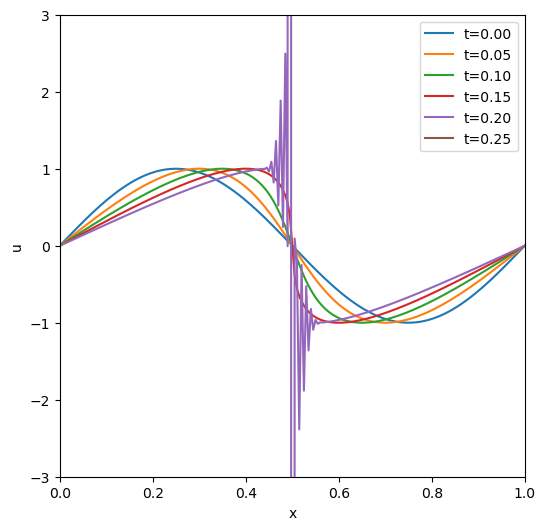

In [11]:
plt.figure(figsize=(6,6))
plt.xlabel("x")
plt.ylabel("u")
plt.xlim((0,1))
plt.ylim((-3,3))
#plt.title("Comparison of theoritical and numerical values @ t = 1")
for i in range(0, NT + 500, 500):    
    plt.plot(x, U[i], label=f't={(i*dt):2.2f}')
plt.legend()
plt.show()